In [31]:
import os
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from keras.regularizers import l2
import tensorflow as tf
import sklearn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Dense,Conv2D
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout
import numpy as np


Visualizing Classes

In [32]:
base_path = 'D:/fer2013plus/'

train_dir = os.path.join(base_path, 'train/')
test_dir = os.path.join(base_path, 'test/')

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [33]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
neutral,10308,2597
happiness,7528,1827
surprise,3562,900
sadness,3514,856
anger,2466,644
fear,652,167
disgust,191,57
contempt,165,51


<Axes: >

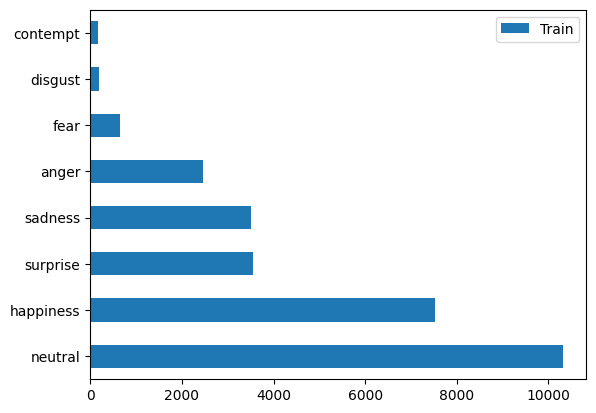

In [34]:
Train_Count.plot(kind='barh')

<Axes: >

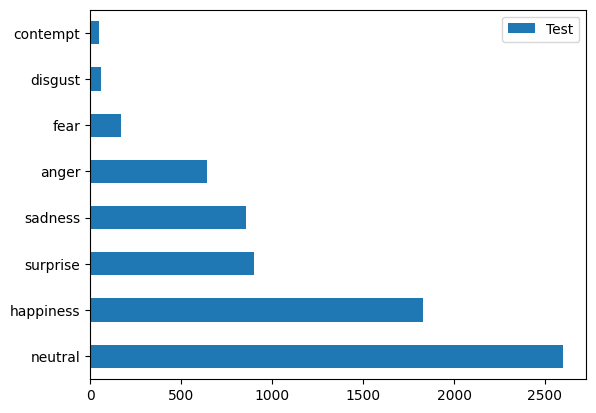

In [35]:
Test_Count.plot(kind='barh')

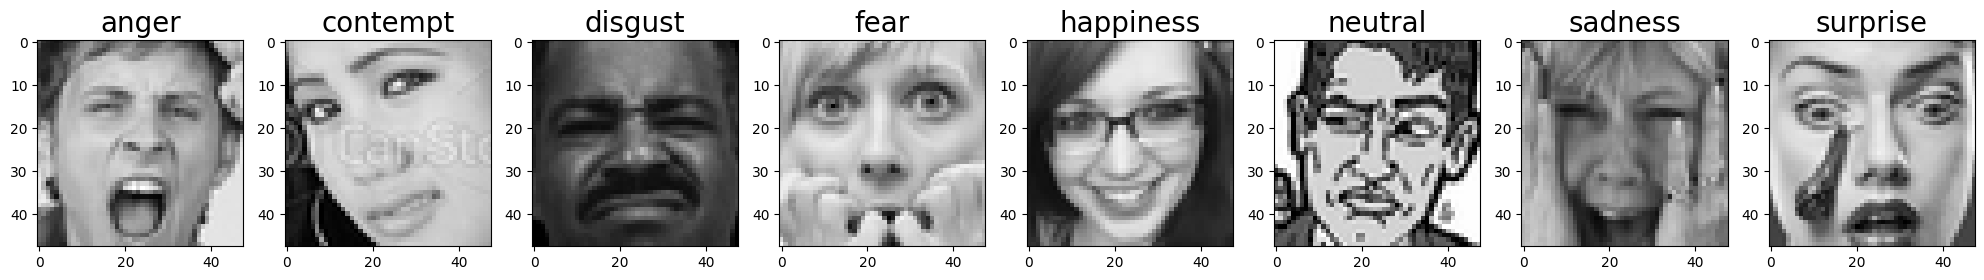

In [36]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL =os.path.join(base_path, 'test/')




for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 8, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

Data Preprocessing

In [37]:
img_shape = 224
batch_size = 64

train_data_path = os.path.join(base_path, 'test/')
test_data_path =os.path.join(base_path, 'train/')

In [38]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
)

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 7099 images belonging to 8 classes.
Found 28386 images belonging to 8 classes.


ResNet50V2 Model

In [39]:

input_shape =  (224,224, 3)
num_classes = 7

steps_per_epoch = train_data.n // batch_size
validation_steps = test_data.n // batch_size

In [40]:
ResNet50V2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

ResNet50V2.trainable = False

In [41]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(8, activation='softmax')
                    ])
    return model

In [42]:
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [43]:
ResNet50V2_Model = Create_ResNet50V2_Model()
ResNet50V2_Model.summary()
optimizer = Adam(learning_rate=0.0001) 
ResNet50V2_Model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          1179712   
                                                                 
 batch_normalization_4 (Bat  (None, 5, 5, 64)          256       
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                102464    
                                                      

In [44]:

def create_callbacks():
    checkpoint_path = "ResNet50V2_Model_Checkpoint"
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
    early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True, verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
    
    return [model_checkpoint, early_stopping, reduce_lr]

callbacks = create_callbacks()
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [45]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=100, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 3.8247 - accuracy: 0.2533INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 824s 7s/step - loss: 3.8247 - accuracy: 0.2533 - val_loss: 3.4220 - val_accuracy: 0.5437 - lr: 1.0000e-04
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 2.8102 - accuracy: 0.5043INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 812s 7s/step - loss: 2.8102 - accuracy: 0.5043 - val_loss: 2.5874 - val_accuracy: 0.6507 - lr: 1.0000e-04
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 2.4536 - accuracy: 0.6070INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 802s 7s/step - loss: 2.4536 - accuracy: 0.6070 - val_loss: 2.2478 - val_accuracy: 0.6935 - lr: 1.0000e-04
Epoch 4/100
110/110 [==============================] - ETA: 0s - loss: 2.2166 - accuracy: 0.6540INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 801s 7s/step - loss: 2.2166 - accuracy: 0.6540 - val_loss: 2.0689 - val_accuracy: 0.7071 - lr: 1.0000e-04
Epoch 5/100
110/110 [==============================] - ETA: 0s - loss: 2.0970 - accuracy: 0.6827INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 802s 7s/step - loss: 2.0970 - accuracy: 0.6827 - val_loss: 1.9447 - val_accuracy: 0.7158 - lr: 1.0000e-04
Epoch 6/100
110/110 [==============================] - ETA: 0s - loss: 1.9441 - accuracy: 0.7112INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 807s 7s/step - loss: 1.9441 - accuracy: 0.7112 - val_loss: 1.8617 - val_accuracy: 0.7331 - lr: 1.0000e-04
Epoch 7/100
110/110 [==============================] - ETA: 0s - loss: 1.8236 - accuracy: 0.7335INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 806s 7s/step - loss: 1.8236 - accuracy: 0.7335 - val_loss: 1.7864 - val_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 8/100
110/110 [==============================] - ETA: 0s - loss: 1.7096 - accuracy: 0.7549INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 809s 7s/step - loss: 1.7096 - accuracy: 0.7549 - val_loss: 1.7582 - val_accuracy: 0.7421 - lr: 1.0000e-04
Epoch 9/100
110/110 [==============================] - ETA: 0s - loss: 1.5897 - accuracy: 0.7770INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 827s 8s/step - loss: 1.5897 - accuracy: 0.7770 - val_loss: 1.6782 - val_accuracy: 0.7512 - lr: 1.0000e-04
Epoch 10/100
110/110 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.8006INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 1076s 10s/step - loss: 1.4891 - accuracy: 0.8006 - val_loss: 1.6352 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 11/100
110/110 [==============================] - ETA: 0s - loss: 1.3996 - accuracy: 0.8078INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


INFO:tensorflow:Assets written to: ResNet50V2_Model_Checkpoint\assets


110/110 [==============================] - 1131s 10s/step - loss: 1.3996 - accuracy: 0.8078 - val_loss: 1.5738 - val_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 12/100
110/110 [==============================] - 980s 9s/step - loss: 1.2975 - accuracy: 0.8333 - val_loss: 1.5587 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 13/100
110/110 [==============================] - 814s 7s/step - loss: 1.2305 - accuracy: 0.8424 - val_loss: 1.5248 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 14/100
110/110 [==============================] - 822s 8s/step - loss: 1.1398 - accuracy: 0.8546 - val_loss: 1.4937 - val_accuracy: 0.7572 - lr: 1.0000e-04
Epoch 15/100
110/110 [==============================] - 819s 7s/step - loss: 1.0652 - accuracy: 0.8644 - val_loss: 1.4834 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 16/100
110/110 [==============================] - 1144s 10s/step - loss: 0.9845 - accuracy: 0.8748 - val_loss: 1.4849 - val_accuracy: 0.7490 - lr: 1.0000e-04
Epoch 16: early stopping


In [46]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("Val Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Val Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

444/444 [==============================] - 691s 2s/step - loss: 1.5734 - accuracy: 0.7590
Val Loss: 1.57335
Val Accuracy: 75.90%


In [47]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  

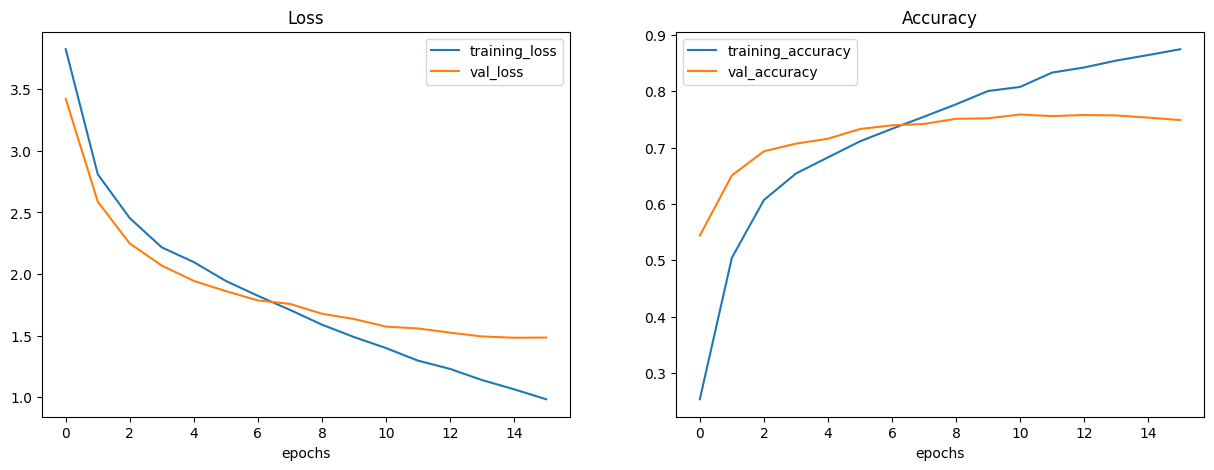

In [48]:
plot_curves(ResNet50V2_history)

In [49]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

444/444 [==============================] - 620s 1s/step


<Figure size 640x480 with 0 Axes>

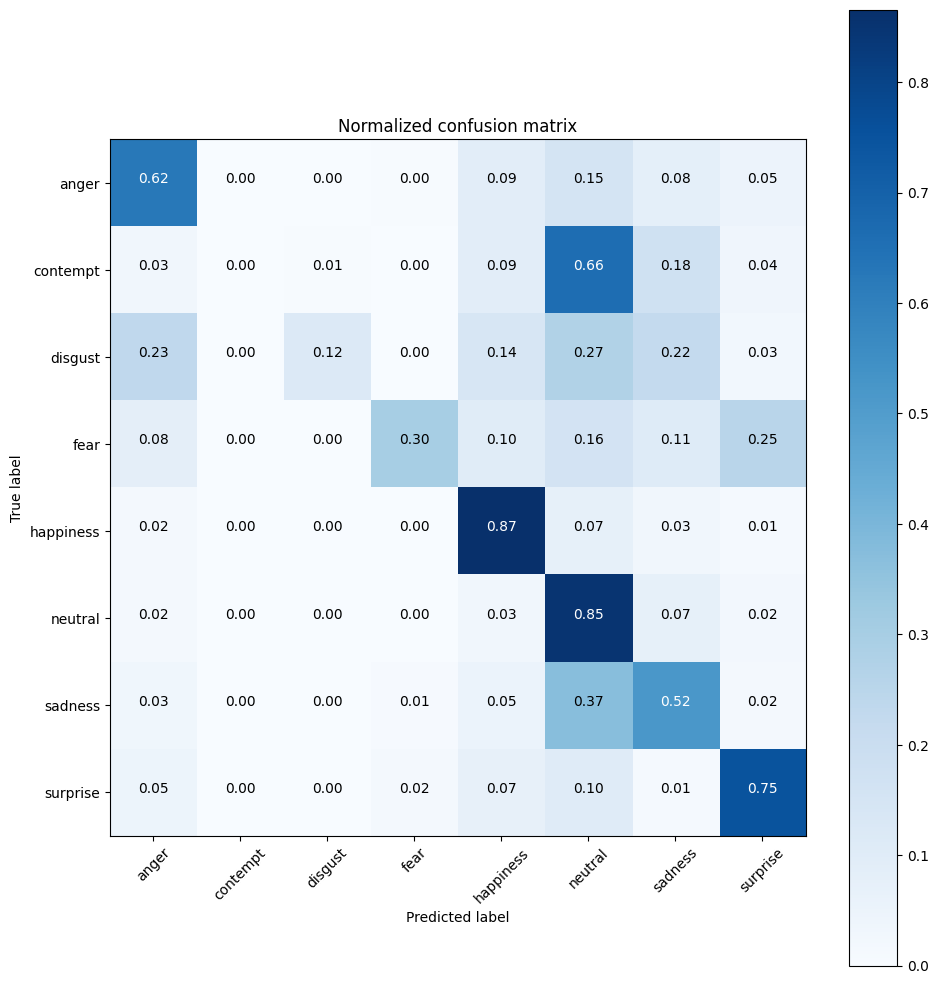

In [56]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(test_data.labels, ResNet50V2_Predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=test_data.class_indices.keys(), title='Normalized confusion matrix')
plt.show()

In [58]:
Emotion_Classes = ['Angry',
                  'contempt'
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sadness', 
                  'Surprise']

In [59]:
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 28386 images belonging to 8 classes.


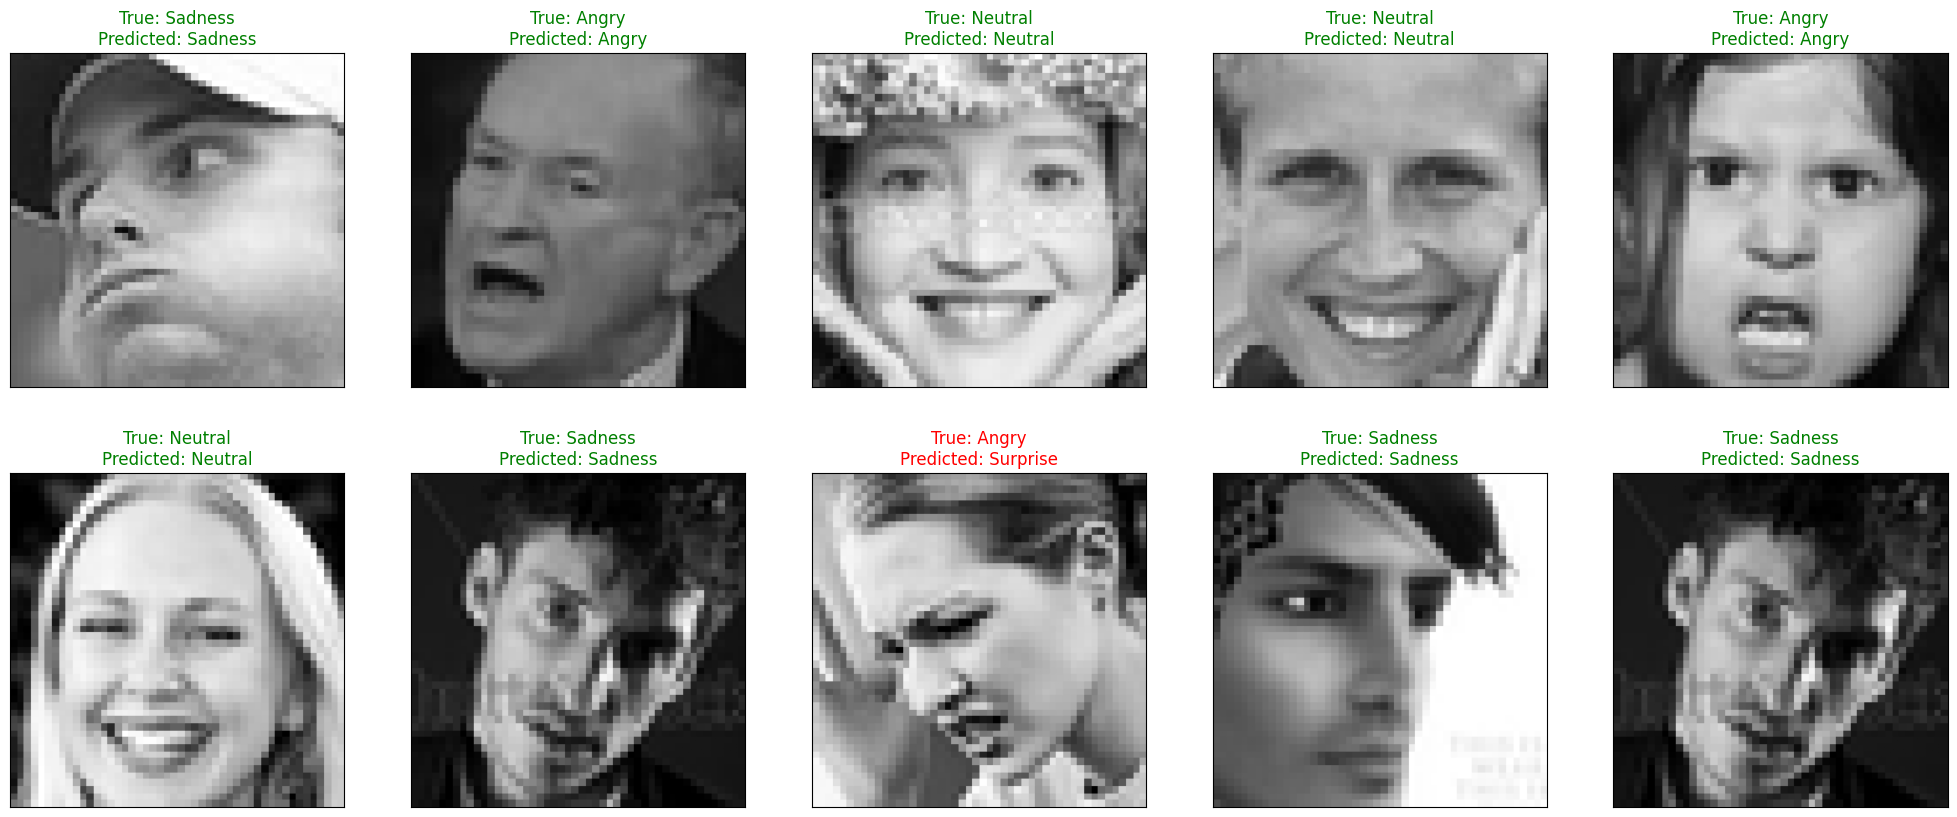

<Figure size 640x480 with 0 Axes>

In [76]:
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()